In [1]:
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
sys.path.insert(1, '../')
import helpers.dataset_stats as ds
import matplotlib.pyplot as plt
import seaborn as sns

# Methods

In [2]:
# converts a bipartite network into a transactional database
def from_bip_to_db(f, idx):
    transactions = defaultdict(set)
    with open(f) as in_f:
        for line in in_f.readlines():
            if "%" in line: continue
            line = line.strip()
            lst = line.split()
            item = int(lst[(idx + 1) % 2])
            trans = int(lst[idx])
            transactions[trans].add(item)
    return np.array(list(transactions.values()))

In [3]:
# retain leng random transactions in the database
def subsample(transactions, leng):
    if len(transactions) > leng:
        sample_idx = set()
        while len(sample_idx) < leng:
            sample_idx.add(random.randint(0, len(transactions)-1))
        return transactions[list(sample_idx)]
    return transactions

In [4]:
# given a transactional database, finds left and right degree distribution, and BJDM 
def compute_degrees_and_BJDM(transactions):
    edges = list()
    left_degrees = defaultdict(int)
    right_degrees = defaultdict(int)
    for idx, t in enumerate(transactions):
        left_degrees[idx] = len(t)
        for item in t:
            edges.append((idx, item))
            right_degrees[item] += 1
    max_len = max(left_degrees.values())
    max_deg = max(right_degrees.values())
    BJDM = np.zeros((max_len, max_deg))
    for edge in edges:
        l = left_degrees[edge[0]]-1
        r = right_degrees[edge[1]]-1
        BJDM[l][r] += 1
    ld = np.zeros(max_len)
    rd = np.zeros(max_deg)
    for v in left_degrees.values():
        ld[v-1] += 1
    for v in right_degrees.values():
        rd[v-1] += 1
    ld = ld.reshape(-1,1)
    rd = rd.reshape(-1,1)
    return BJDM, ld, rd

In [15]:
def find_distance(ds, trans):
    # compute bjdm and marginals - normalize!
    bjdm, ld, rd = compute_degrees_and_BJDM(trans)
    bjdm_n = bjdm / np.sum(bjdm)
    ld_n = ld / np.sum(ld)
    rd_n = rd / np.sum(rd)
    # joint deg dist is the product of the marginals
    joint = (ld_n @ rd_n.T)
    print(bjdm_n.shape, round(np.sum(bjdm_n)), 
          joint.shape, round(np.sum(joint)))
    diff = bjdm_n - joint
    # the larger the distance between bjdm and joint, 
    # the higher the probability that ALICE and GMMT
    # give different results in significant itemset mining
    dist = round(np.linalg.norm(diff, ord='fro'), 5)
    # tentative threshold
    abs_diff = np.abs(diff) * np.sum(bjdm)
    thresh = np.mean(abs_diff) / len(trans)
    print(ds, len(trans), dist, thresh)
    return ld, rd

In [6]:
def get_dataset_stats(transactions):
    num_transactions = len(transactions)
    items = set()
    sum_transaction_lens = 0

    for transaction in transactions:
        for item in transaction:
            items.add(item)
        sum_transaction_lens += len(transaction)

    num_items = len(items)
    avg_transaction_len = sum_transaction_lens / num_transactions
    density = avg_transaction_len / num_items
    # 'Transaction Num', 'Item Num', 'Sum Transaction Lengths', 'AVG Transaction Length', 'Density'
    return [num_transactions, num_items, sum_transaction_lens, avg_transaction_len, density]

In [7]:
def write_db(f, transactions):
    with open(f, 'w') as out_f:
        for t in transactions:
            out_f.write(' '.join([str(x) for x in t])+'\n')

# Setup

In [8]:
data_dir = '../datasets/bipartite'
out_dir = '../datasets'

In [9]:
bip_graphs = ['gottron-reuters', 'bag-kos', 'dbpedia-occupation', 
              'movielens-100k_rating', 'edit-iewikibooks', 
              'librec-filmtrust-ratings', 'wang-tripadvisor', 
              'moreno_crime']
# if the transaction is the left or right node
side = {
    'gottron-reuters' : 0,
    'bag-kos' : 0,
    'dbpedia-occupation' : 0,
    'movielens-100k_rating' : 0,
    'edit-iewikibooks' : 0,
    'librec-filmtrust-ratings' : 0,
    'wang-tripadvisor' : 0,
    'moreno_crime' : 0
}

In [10]:
max_size = 10000

# Generation

In [11]:
dbs = dict()

In [160]:
for ds in bip_graphs:
    file_name = f'{data_dir}/{ds}/out.{ds}'
    # generate database
    trans = from_bip_to_db(file_name, side[ds])
    # sub-sample from db
    trans = subsample(trans, max_size)
    dbs[ds] = trans
    # find distance
    find_distance(ds, trans)

(380, 9659) 1 (380, 9659) 1
gottron-reuters 10000 0.058 2.1544970710719304e-05
(457, 2123) 1 (457, 2123) 1
bag-kos 3430 0.00958 0.00011779562486871651
(18, 1394) 1 (18, 1394) 1
dbpedia-occupation 10000 0.32214 8.293752647487876e-05
(737, 583) 1 (737, 583) 1
movielens-100k_rating 943 0.01303 0.000333226717016403
(181, 7) 1 (181, 7) 1
edit-iewikibooks 137 0.49284 0.004783716913068563
(244, 1044) 1 (244, 1044) 1
librec-filmtrust-ratings 1508 0.09904 0.00016361178647119096
(22, 152) 1 (22, 152) 1
wang-tripadvisor 10000 0.17212 0.0002928067004315967
(25, 18) 1 (25, 18) 1
moreno_crime 829 0.28021 0.0036225142425240654


In [ ]:
find_distance('kosarak_3000', )

# Save Candidate DB

# Statistics

In [12]:
db_name = 'edit-iewikibooks'

In [16]:
transactions = list()
with open(f'../datasets/{db_name}.txt') as in_f:
    for line in in_f.readlines():
        transactions.append([int(x) for x in line.strip().split()])
transactions = np.array(transactions)
ld, rd = find_distance(db_name, transactions)

(181, 7) 1 (181, 7) 1
edit-iewikibooks 137 0.49284 0.004783716913068563


/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_49196/1959491975.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  transactions = np.array(transactions)


In [28]:
left_dist = pd.DataFrame(ld).reset_index()
left_dist.columns = ['Length', 'Count']
left_dist['Length'] = left_dist['Length'] + 1
left_dist = left_dist[left_dist['Count']>0]

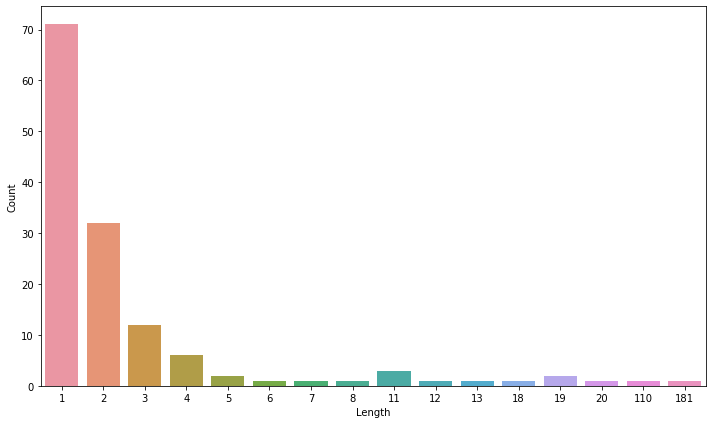

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=left_dist, x='Length', y='Count')
plt.tight_layout()
plt.show()

In [141]:
subT = subsample(transactions, max_size)
find_distance(db_name, subT)

In [162]:
write_db(f'{out_dir}/{db_name}.txt', dbs[db_name])